In [1]:
import scvi
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt


from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde
import pygot

import warnings
from lightning_fabric.plugins.environments.slurm import PossibleUserWarning
warnings.simplefilter(action='ignore', category=PossibleUserWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pygot
scvi.settings.seed = 42
%matplotlib inline

/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
Seed set to 42


In [2]:
# 2022 TOME definition

file = open("../pygot_data/TOME/tome_code/help_code/mouse_celltype_group.txt")
i = 1
fx_map = {}
cell_type_classification = {'Unknown':'Unknown'}
for line in file:
    l = line.rstrip().split("\t")
    cell_type_classification[l[0]] = int(l[1])
    fx_map[l[0]] = i
    i += 1


file.close()
fx_map['ICM'] = 97
fx_map['16C'] = 98
fx_map['8C'] = 98
fx_map['4C'] = 98
fx_map['2C'] = 98
fx_map['Zygote'] = 98
fx_map['Primitive endoderm'] = 100
fx_map['Unknown'] = 0
cell_type_classification['Zygote'] = 0
cell_type_classification['2C'] = 0
cell_type_classification['4C'] = 0
cell_type_classification['8C'] = 0
cell_type_classification['16C'] = 0
cell_type_classification['ICM'] = 0
cell_type_classification['Trophectoderm'] = 0
cell_type_classification['Primitive endoderm'] = 0

## Preprocess

In [171]:
adata_2 = sc.read('../pygot_data/TOME/E8.5b_E13.5.h5ad')

Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].


In [172]:
adata_2.obs['day'].unique()

['E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']
Categories (6, object): ['E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [173]:
batch_map = {
    'E8.5b':'Qiu',
    'E9.5':'Cao',
    'E10.5':'Cao',
    'E11.5':'Cao',
    'E12.5':'Cao',
    'E13.5':'Cao',
    
}

adata_2.obs['batch'] = adata_2.obs['day'].replace(batch_map)
adata_2.obs['batch']

P2-01A.ATTCAAGCATGTTACGCAAG         Qiu
P2-01A.CCGTCGATTTTATTCTGAG          Qiu
P2-01A.ATGGTAACTTAGCCGGTACC         Qiu
P2-01A.CCGACCAATTTGCGAGGCA          Qiu
P2-01A.ATGCTTCCTAATGCCGCTT          Qiu
                                   ... 
sci3-me-760.ATATGGATCTACGTTCAACC    Cao
sci3-me-760.GCGGTATATAGGTCAATTA     Cao
sci3-me-760.CCTCCTGATTTGGAGTCGG     Cao
sci3-me-760.GAGACTAGTAGCTAAGGTA     Cao
sci3-me-760.GTTCGCTGTAGGTCAATTA     Cao
Name: batch, Length: 1547878, dtype: category
Categories (2, object): ['Qiu', 'Cao']

In [174]:
adata_2.obs['experiment'] = adata_2.obs['batch']
adata_2.obs['timepoint'] = adata_2.obs['day']

In [175]:
early_adata = adata_2

In [176]:
stage_numeric = {
    'E8.5b': 'E8.5'
}
early_adata.obs['stage_numeric'] = early_adata.obs['timepoint'].replace(stage_numeric).astype(str)
early_adata.obs['stage_numeric'] = early_adata.obs['stage_numeric'].apply(lambda x :  float(x[1:]))

In [177]:
early_adata.raw = early_adata

In [178]:
meta = pd.read_csv('../pygot_data/development/E8_5_13_5/cell_annotate.csv')
meta = meta.set_index('sample')
idx = meta.index.intersection(early_adata.obs.index)
early_adata.obs['batch'] = early_adata.obs['batch'].astype(str)
early_adata.obs.loc[idx, 'batch'] = meta.loc[idx]['embryo_id']
idx = early_adata.obs.loc[early_adata.obs['somite_stage'] == early_adata.obs['somite_stage']].index
early_adata.obs.loc[idx, 'batch'] = early_adata.obs.loc[idx]['somite_stage']
idx = meta.index.intersection(early_adata.obs.index)
early_adata.obs['batch'] = early_adata.obs['batch'].astype(str)
early_adata.obs['known'] = '1'
early_adata.obs.loc[early_adata.obs['batch'].str.startswith('sci'), 'known'] = '0'
early_adata = early_adata[early_adata.obs['known'] == '1']

In [179]:
early_adata

View of AnnData object with n_obs × n_vars = 1547878 × 24552
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'day', 'group', 'cell_state', 'cell_type', 'somite_stage', 'batch', 'experiment', 'timepoint', 'stage_numeric', 'known'
    var: 'name'

In [180]:
early_adata.layers['counts'] = early_adata.X.copy()

In [181]:

sc.pp.normalize_total(early_adata)
sc.pp.log1p(early_adata)

In [182]:
early_adata.obs['experiment'].unique()

['Qiu', 'Cao']
Categories (2, object): ['Qiu', 'Cao']

In [184]:
sc.pp.highly_variable_genes(
    early_adata,
    flavor="cell_ranger",
    n_top_genes=3_000,
    batch_key="timepoint",
    #layer='counts',
    subset=True,
)

... storing 'batch' as categorical
... storing 'known' as categorical


In [185]:
sc.write('../pygot_data/development/E8.5b_E13.5_hvg.h5ad', early_adata)

Only considering the two last: ['.5_hvg', '.h5ad'].
Only considering the two last: ['.5_hvg', '.h5ad'].


## Integration

In [44]:
early_adata = sc.read('../pygot_data/development/E8.5b_E13.5_hvg.h5ad')

Only considering the two last: ['.5_hvg', '.h5ad'].
Only considering the two last: ['.5_hvg', '.h5ad'].


In [5]:
del early_adata.raw

In [ ]:
early_adata

In [191]:
adata = early_adata

In [6]:
def scvi_scanvi_pipeline(ad, batch_key='batch'):
    print('Convert into dense matrix')
    ad.layers['counts'] = ad.layers['counts'].toarray()
    print('Setup adata')
    scvi.model.SCVI.setup_anndata(
        ad, 
        layer="counts", 
        batch_key=batch_key,
    )
    
    print('Train scVI')
    vae = scvi.model.SCVI(ad, n_layers=2, n_latent=30, gene_likelihood='nb')
    vae.train( max_epochs=400, early_stopping=True)
    pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line(marker='o')
    ad.obsm["X_scVI"] = vae.get_latent_representation(ad)
    
    print('scVI umap')
    sc.pp.neighbors(ad, use_rep='X_scVI', n_neighbors=50)
    sc.tl.umap(ad, min_dist=0.3)
    sc.pl.umap(ad, color=['experiment','batch',  'timepoint' ,'cell_type', 'stage_numeric'], ncols=1, cmap='Spectral_r')
    ad.obsm['X_scVI_umap'] = ad.obsm['X_umap']
    
    return vae

Convert into dense matrix

Setup adata

Train scVI

2025-01-22 00:33:30,169 - INFO - Created a temporary directory at /tmp/tmpswr3am6x
2025-01-22 00:33:30,174 - INFO - Writing /tmp/tmpswr3am6x/_remote_module_non_scriptable.py
2025-01-22 00:33:30,691 - INFO - GPU available: True (cuda), used: True
2025-01-22 00:33:30,692 - INFO - TPU available: False, using: 0 TPU cores
2025-01-22 00:33:30,693 - INFO - HPU available: False, using: 0 HPUs
2025-01-22 00:33:30,731 - INFO - You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

2025-01-22 15:00:49,340 - INFO - `Trainer.fit` stopped: `max_epochs=400` reached.


scVI umap

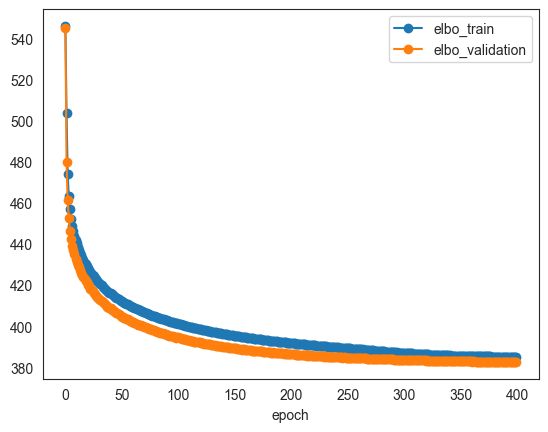

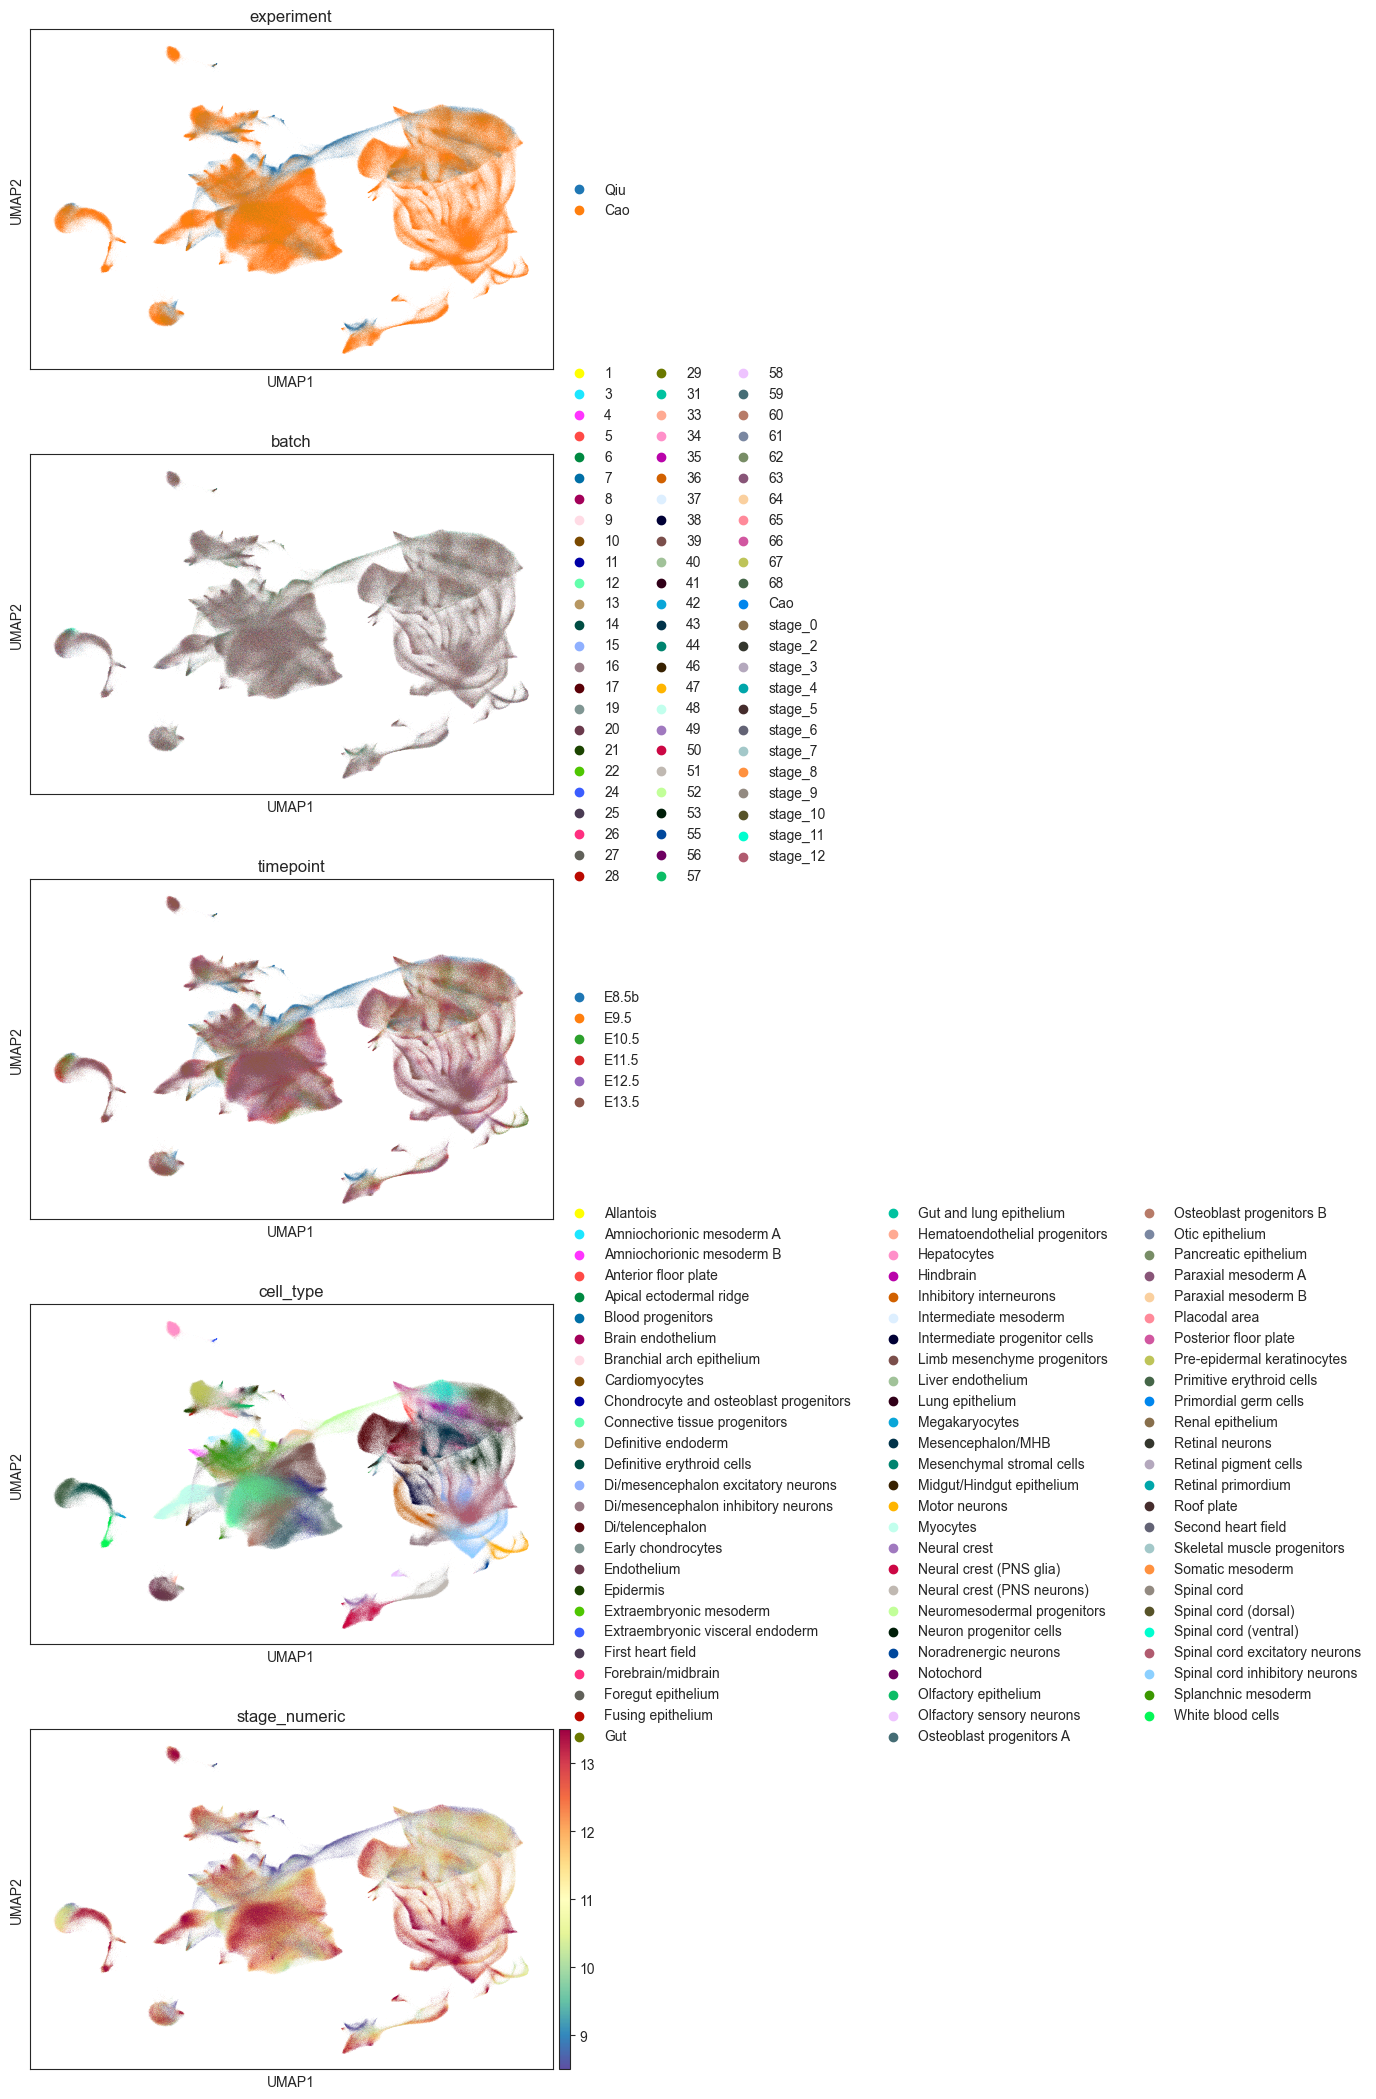

In [7]:
vae = scvi_scanvi_pipeline(early_adata)

In [8]:
vae.save('../pygot_data/development/E8_5_13_5/scvi_model', overwrite=True)

In [9]:
sc.write('../pygot_data/development/E8_5_13_5/adata_processed.h5ad',early_adata)

## Flow model training

In [25]:
adata = sc.read('../pygot_data/development/E8_5_13_5/adata_processed.h5ad')


In [7]:
import pygot
model, _ = pygot.tl.traj.fit_velocity_model(adata, embedding_key='X_scVI', time_key='stage_numeric', 
                                            path='../pygot_data/development/E8_5_13_5/scVI_path/',
                                           v_centric_batch_size=1024, x_centric_batch_size=1024, v_centric_iter_n=1000, x_centric_iter_n=10000, landmarks=True)

loading saved shortest path profile
[Errno 2] No such file or directory: '../pygot_data/development/E8_5_13_5/scVI_path_2//_9.5to10.5.pkl'
Error in loading shortest path file
calcu shortest path between 8.5 to 9.5
Fit 25000 landmarks by FAISS KMean


WARNING clustering 265391 points to 25000 centroids: please provide at least 975000 training points


Clustering 265391 points in 30D to 25000 clusters, redo 1 times, 1000 iterations
  Preprocessing in 0.01 s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [11:39<00:00, 35.75it/s]


calcu shortest path between 9.5 to 10.5
Fit 25000 landmarks by FAISS KMean


WARNING clustering 380591 points to 25000 centroids: please provide at least 975000 training points



Clustering 380591 points in 30D to 25000 clusters, redo 1 times, 1000 iterations
  Preprocessing in 0.01 s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [11:01<00:00, 37.77it/s]


calcu shortest path between 10.5 to 11.5
Fit 25000 landmarks by FAISS KMean


WARNING clustering 724637 points to 25000 centroids: please provide at least 975000 training points



Clustering 724637 points in 30D to 25000 clusters, redo 1 times, 1000 iterations
  Preprocessing in 0.02 s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [11:53<00:00, 35.05it/s]


calcu shortest path between 11.5 to 12.5
Fit 25000 landmarks by FAISS KMean


WARNING clustering 747850 points to 25000 centroids: please provide at least 975000 training points



Clustering 747850 points in 30D to 25000 clusters, redo 1 times, 1000 iterations
  Preprocessing in 0.02 s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [11:25<00:00, 36.45it/s]


calcu shortest path between 12.5 to 13.5
Fit 25000 landmarks by FAISS KMean


WARNING clustering 557850 points to 25000 centroids: please provide at least 975000 training points



Clustering 557850 points in 30D to 25000 clusters, redo 1 times, 1000 iterations
  Preprocessing in 0.02 s


loss :29.2699  best :29.2699:   0%|                                                                                                                                                               | 1/10000 [00:03<9:24:01,  3.38s/it]

loss :17.3587  best :17.3349: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:05:05<00:00,  1.33it/s]


In [31]:
import torch
torch.save(model, '../pygot_data/development/E8_5_13_5/got_scVI.pkl', )

## Life roadmap inference

In [5]:
import torch
adata = sc.read('../pygot_data/development/E8_5_13_5/adata_processed.h5ad')
model = torch.load( '../pygot_data/development/E8_5_13_5/got_scVI.pkl',map_location=torch.device('cpu') )
print(adata.obsm['X_scVI'].shape)


(1547878, 50)

In [6]:
gene_meta = pd.read_table("../pygot_data/TOME/tome_code/help_code/mouse.v12.geneID.txt").set_index('gene_ID')
overlap_idx = adata.var.index.intersection(gene_meta.index)
adata.var['gene_name'] = adata.var.index
adata.var.loc[overlap_idx, 'gene_name'] = gene_meta.loc[overlap_idx]['gene_short_name']
adata.var = adata.var.set_index('gene_name')

In [20]:
## Export data for run moscot
## Use all genes adata for compute marginal distribution of moscot, because hvg do not contain growth genes


#early_adata = sc.read('../pygot_data/development/E8.5b_E13.5_hvg.h5ad')
#adata.raw = early_adata.raw.to_adata()
#raw_adata = adata.raw.to_adata()
#sc.pp.normalize_total(raw_adata)
#sc.pp.log1p(raw_adata)

#gene_meta = pd.read_table("../pygot_data/TOME/tome_code/help_code/mouse.v12.geneID.txt").set_index('gene_ID')
#overlap_idx = raw_adata.var.index.intersection(gene_meta.index)
#raw_adata.var['gene_name'] = raw_adata.var.index
#raw_adata.var.loc[overlap_idx, 'gene_name'] = gene_meta.loc[overlap_idx]['gene_short_name']
#raw_adata.var = raw_adata.var.set_index('gene_name')
#raw_adata.var_names_make_unique()
#raw_adata.obsm['X_scVI'] = adata.obsm['X_scVI']
#sc.write('../pygot_data/development/E8_5_13_5/adata_processed_all.h5ad', raw_adata)

In [7]:
embedding_key = 'X_scVI'
velocity_key = 'velocity_scVI'
time_key = 'stage_numeric'
cell_type_key = 'cell_type'

In [ ]:

vae = scvi.model.SCVI.load('../pygot_data/development/E8_5_13_5/scvi_model', adata )
adata.obsm['velocity_scVI'] = pygot.tl.traj.latent_velocity(adata, model, embedding_key='X_scVI', time_key='stage_numeric')
#ad.layers['velocity'] = pygot.tl.traj.latent2gene_velocity_scVI(ad, 'X_scVI', 'velocity_scVI', vae)
inverse_transform = pygot.tl.traj.flow.get_inverse_transform_func_scVI(vae=vae, adata=adata)
velocity_numeric = pygot.tl.traj.velocity(adata, model, embedding_key='X_scVI', time_key='stage_numeric', dr_mode='nonlinear', inverse_transform=inverse_transform, dt=0.001)
adata.layers['velocity'] = velocity_numeric
pygot.tl.traj.velocity_graph(adata, embedding_key='X_scVI', velocity_key='velocity_scVI')


computing velocity embedding
    finished (0:02:34) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


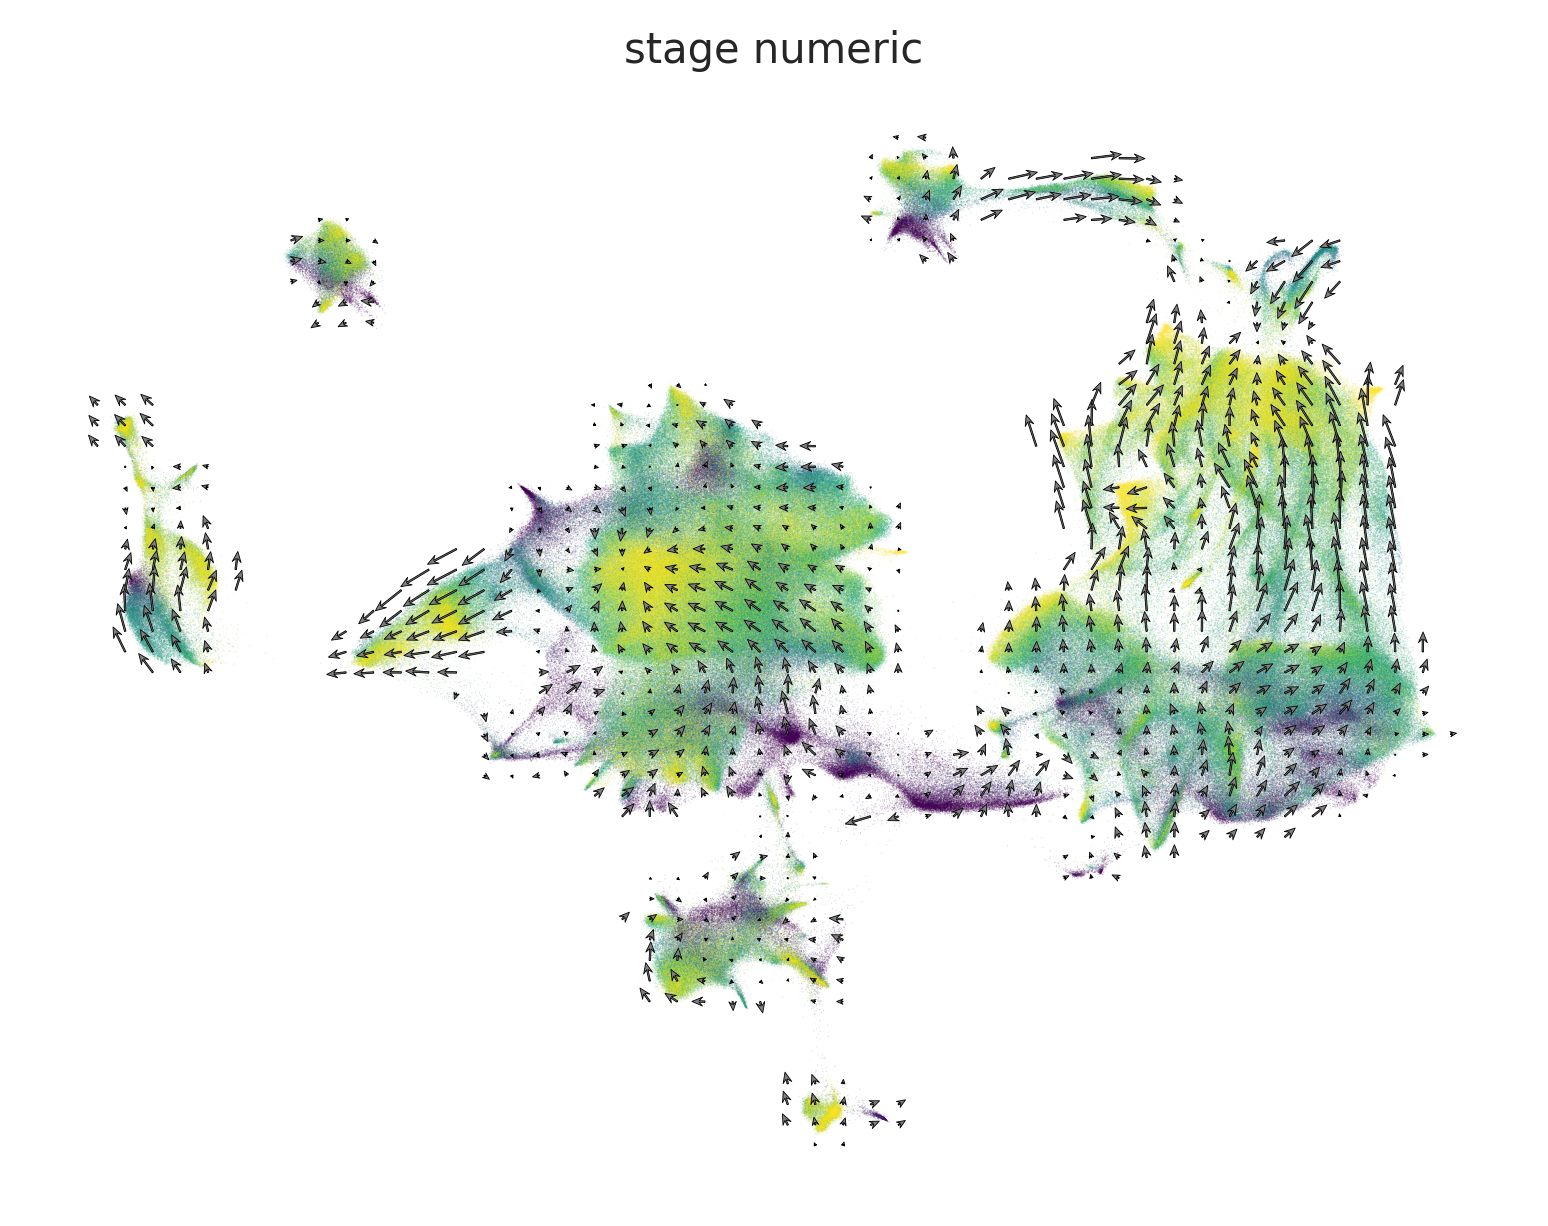

In [10]:
import scvelo as scv
fig, ax = plt.subplots(1,1, dpi=300)

scv.pl.velocity_embedding_grid(adata, color='stage_numeric', legend_loc='none', ax=ax, arrow_length=1.5, arrow_size=1.2, colorbar=False, show=False)
plt.savefig('/disk/share/xuruihong/pygot_fig/development_E8.5_E13.5.png', format='png')

In [8]:
adata.obsm['velocity_scVI'] = pygot.tl.traj.latent_velocity(adata, model, embedding_key='X_scVI', time_key='stage_numeric')

In [9]:
roadmap = pygot.tl.analysis.TimeSeriesRoadmap(adata, embedding_key, velocity_key, time_key, sde=True, D=1.)
roadmap.compute_state_coupling(cell_type_key=cell_type_key, mutual=True, n_neighbors=30)

2025-04-02 15:23:56 	 Compute transition roadmap among [ 8.5  9.5 10.5 11.5 12.5 13.5]
2025-04-02 15:23:56 	 Compute transition between 8.5 and 9.5
2025-04-02 15:24:22 	 Compute velocity graph
Isolated node: 2.8147%
Scale factor: 0.2612043
Scale factor: 0.2612043
2025-04-02 15:26:55 	 Convert into markov chain
2025-04-02 15:26:56 	 Solve abosorbing probabilities
2025-04-02 15:29:49 	 Generate NULL distribution
2025-04-02 15:29:59 	 Compute transition between 9.5 and 10.5
2025-04-02 15:30:23 	 Compute velocity graph
Isolated node: 3.1299%
Scale factor: 0.2602176
Scale factor: 0.2602176
2025-04-02 15:33:30 	 Convert into markov chain
2025-04-02 15:33:31 	 Solve abosorbing probabilities
2025-04-02 15:37:25 	 Generate NULL distribution
2025-04-02 15:37:43 	 Compute transition between 10.5 and 11.5
2025-04-02 15:43:45 	 Compute velocity graph
Isolated node: 3.3370%
Scale factor: 0.2633714
Scale factor: 0.2633714
2025-04-02 15:49:50 	 Convert into markov chain
2025-04-02 15:49:53 	 Solve abo

In [29]:
filtered_back_state_coupling_list = roadmap.filter_state_coupling()

In [31]:
def summary_road_map(back_state_coupling_list, processed_state_dist_list, ts, cutoff=0.):
    
    def process(state_coupling, traj_dist_coupling, i):
        df = state_coupling.copy()
        df.index = df.index.to_series().apply(lambda x: 'E'+str(ts[i])+':'+x)
        df.columns = df.columns.to_series().apply(lambda x: 'E'+str(ts[i+1])+':'+x)
        df = pd.DataFrame(df.stack()).reset_index()
        if traj_dist_coupling is None:
            traj_dist = 0.
        else:
            traj_dist = pd.DataFrame(traj_dist_coupling.fillna(0).stack()).reset_index()[0]
        df.columns = ['from', 'to', 'weight']
        df['dist'] = traj_dist
        df = df.loc[df['weight'] > cutoff]
        
        return df
    all_df = []
    for i in range(len(ts) - 1):
        if processed_state_dist_list is None:
            all_df.append(process(back_state_coupling_list[i], None, i))
        else:
            all_df.append(process(back_state_coupling_list[i], processed_state_dist_list[i], i))
    return pd.concat(all_df).reset_index(drop=True)

ts = np.sort(np.unique(adata.obs[time_key]))
cell_type_class_names = ['Other', 'Neuroectoderm', 'Surface ectoderm', 'Endoderm', 'Mesoderm', 'ExE embryo']
summary = summary_road_map(filtered_back_state_coupling_list, None, ts, cutoff=0.)
node_profile = pd.DataFrame(np.unique(list(summary['from']) + list(summary['to'])), columns=['name'])
node_profile['group'] = node_profile['name'].apply(lambda x: cell_type_class_names[cell_type_classification[x.split(':')[1]]])
node_profile['position'] = node_profile['name'].apply(lambda x: fx_map[x.split(':')[1]])
node_profile['cell_state'] = node_profile['name'].apply(lambda x: x.split(':')[1])
node_profile['stage'] = node_profile['name'].apply(lambda x: float(x.split(':')[0][1:]))

In [32]:
node_profile['x'] = node_profile['stage'].replace(dict(zip(np.sort(np.unique(node_profile['stage'])), range(len(np.sort(np.unique(node_profile['stage'])))) )))

In [33]:
summary.to_csv('../pygot_data/development/road_map_edge_E8.5-E13.5_sde.csv', index=False)
node_profile.to_csv('../pygot_data/development/road_map_node_E8.5-E13.5_sde.csv', index=False)

In [34]:
a = pd.read_csv('../pygot_data/development/road_map_edge_E0.5-E8.5_sde.csv')
b = pd.read_csv('../pygot_data/development/road_map_edge_E8.5-E13.5_sde.csv')

pd.concat([a,b]).to_csv('../pygot_data/development/road_map_edge_E0.5-E13.5_sde.csv', index=False)

In [35]:
a = pd.read_csv('../pygot_data/development/road_map_node_E0.5-E8.5_sde.csv')
b = pd.read_csv('../pygot_data/development/road_map_node_E8.5-E13.5_sde.csv')
res = pd.concat([a,b]).drop_duplicates(['cell_state', 'stage'])
res['x'] = res['stage'].replace(dict(zip(np.sort(np.unique(res['stage'])), range(len(np.sort(np.unique(res['stage'])))) )))
res.to_csv('../pygot_data/development/road_map_node_E0.5-E13.5_sde.csv', index=False)
